In [1]:
import requests
import json
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
FS = 16
import seaborn as sns
sns.set(style='ticks')

# Football-data.org
I can use this API to get a list of all teams and players in the 2018 World Cup

In [52]:
# Get a list of all teams in the 2018 World Cup
uri = "http://api.football-data.org/v1/competitions/467/teams"
response = requests.get(uri)
assert response.status_code == 200, "Error in API request."
team_data = response.json()

In [64]:
# Get player data for each team in the 2018 World Cup
# soccer_data = []
num_teams = team_data['count']
for n,team in enumerate(team_data['teams']):
    print("({n}/{total}) {name}".format(n=n+1, total=num_teams, name=team['name']))    
    try:
        response = requests.get(team['_links']['players']['href'])
        assert response.status_code == 200, "Error in API request ({}).".format(n)
        team['players'] = response.json()
        soccer_data.append(team)    
    except Exception as e:
        print("Football-data Error: {error}".format(error=e))
    time.sleep(5)
    
# Save the data
print("Saving the data...", end="", flush=True)
with open('soccer_teams.json', 'w') as outfile:
    json.dump(soccer_data, outfile)
print(" Done.")

(1/32) Russia
(2/32) Saudi Arabia
(3/32) Egypt
(4/32) Uruguay
(5/32) Morocco
(6/32) Iran
(7/32) Portugal
(8/32) Spain
(9/32) France
(10/32) Australia
(11/32) Argentina
(12/32) Iceland
(13/32) Peru
(14/32) Denmark
(15/32) Croatia
(16/32) Nigeria
(17/32) Costa Rica
(18/32) Serbia
(19/32) Germany
(20/32) Mexico
(21/32) Brazil
(22/32) Switzerland
(23/32) Sweden
(24/32) Korea Republic
(25/32) Belgium
(26/32) Panama
(27/32) Tunisia
(28/32) England
(29/32) Colombia
(30/32) Japan
(31/32) Poland
(32/32) Senegal
Saving the data... Done.


In [72]:
player_count = 0
for team in soccer_data:
    print("-"*50 + '\n' + team['name'])
    for player in team['players']['players']:
        print(player['name'])
        player_count += 1
        
print("Total players: {}".format(player_count))

--------------------------------------------------
Russia
Denis Cheryshev
Ilya Kutepov
Roman Zobnin
Aleksandr Samedov
Igor Akinfeev
Sergey Ignashevich
Mário Fernandes
Alan Dzagoev
Aleksandr Golovin
Andrey Lunev
Vladimir Gabulov
Andrey Semenov
Vladimir Granat
Fedor Kudryashov
Igor Smolnikov
Daler Kuzyaev
Yuri Gazinskiy
Anton Miranchuk
Yuri Zhirkov
Aleksey Miranchuk
Aleksandr Erokhin
Fedor Smolov
Artem Dzyuba
--------------------------------------------------
Saudi Arabia
Yahya Al-Shehri
Fahad Al-Muwallad
Salem Al-Dawsari
Mohammed Al-Owais
Yasser Al-Mosailem
Abdullah Al-Muaiouf
Assaf Al Qarni
Motaz Hawsawi
Mohammed Jahfali
Omar Hawsawi
Osama Hawsawi
Ali Al-Boleahi
Yasir Al-Shahrani
Mansour Al-Harbi
Mohammed Al-Burayk
Saeed Al-Mowalad
Abdullah Ateef
Abdulmalek Al-Khaibri
Abdullah Al-Khaibari
Salman Al-Faraj
Hussein Al Moghawi
Taisir Al-Jassim
Mohamed Kanu
Nawaf Al-Abed
Hattan Bahbir
Mohammed Al-Kuwaykibi
Muhannad Asiri
Mohammed Al-Sahlawi
--------------------------------------------------

# SportRadar API

In [2]:
# Load the API credentials
with open("secrets_sportradar.txt",'r') as f:
    soccer_api_key = f.readlines()[0].split(': ')[1].strip()

In [3]:
class SportRadarAPI(object):
    """Interface with the Sportradar Soccer INTL API"""
    # Really this should be a super class from which the specific INTL API would inherit
    
    _BASE_URL = "https://api.sportradar.us/soccer-t3/intl/en"
    
    def __init__(self, api_key, format='json'):
        self._FORMAT = "." + format.strip(".")
        self._KEY = api_key
        
    def _make_get_request(self, partial_uri):
        """Make a GET reuest to the SportRadar API"""
        URI = self._BASE_URL + "/" + partial_uri + self._FORMAT
        response = requests.get(URI, params={'api_key': self._KEY})
        assert response.status_code == 200, "Error in API request. Status: {}".format(response.status_code)       
        return response
    
    def get_tournaments(self):
        """Provides the list of International Soccer tournaments"""
        URI = "tournaments".format(_id=player_id)
        return self._make_get_request(URI)
    
    def get_tournament_info(self, tournament_id):
        """Provides information for International Soccer tournaments"""
        # tournament_id is found via get_tournaments and follows the sr:tournament:num format
        URI = "tournaments/{_id}/info".format(_id=tournament_id)
        return self._make_get_request(URI)
    
    def get_team_profile(self, team_id):
        """Team information, including player roster information"""
        URI = "teams/{_id}/profile".format(_id=team_id)
        return self._make_get_request(URI)
        
    def get_player_profile(self, player_id):
        """"""
        URI = "players/{_id}/profile.{_format}".format(_id=player_id)
        return self._make_get_request(URI)                

### Scrape data from the SportRadar API

In [115]:
# Create an instance of the SportRadar API class
sportsradar = SportRadarAPI(soccer_api_key)

# Get a list of all tournaments
tournaments = sportsradar.get_tournaments().json()

# Get info on the 2018 World Cup (Teams, Rounds, etc.)
worldcup = sportsradar.get_tournament_info(tournaments['tournaments'][4]['id']).json()

# Get more information on each team in the World Cup
teams = []
team_counter = 0
for group in worldcup['groups']:
    for team in group['teams']:
        team_counter += 1
        team_id = team['id']
        team_name = team['name']
        print("({}): {}, {}".format(team_counter, team_name, team_id))
        try:
            teams.append(sportsradar.get_team_profile(team_id).json())
        except Exception as e:
            print("Error: {}".format(e))
        time.sleep(5) # wait 5 seconds before next API call
        
# Save the team data to a .json file
print("Saving the data...", end="", flush=True)
with open("world_cup_team_data.json", "w") as outfile:
    json.dump(teams, outfile)
print(" Done.")

---
---
# Load the World Cup team data

In [2]:
teams = json.loads(open("world_cup_team_data.json", "r").read())
teams[23]['team']['name'] = 'South Korea'
teams[23]['team']['country'] = 'South Korea'
# Combine all player data into a single list
players = [[p for p in team['players']] for team in teams]
players = [item for sublist in players for item in sublist]

# Create a DataFrame from the list of players
df = pd.DataFrame(players)
df['weight_lbs'] = df.weight*2.20462
df['height_ft'] = df.height*0.03280841666667
# df['date_of_birth'] = pd.to_datetime(df['date_of_birth'])
df.at[df.nationality=="Republic of Korea", 'nationality'] = "South Korea"
df.head()

country_code date_of_birth gender  height                id  jersey_number  \
0          RUS    1986-04-08   male     185   sr:player:13274              1   
1          RUS    1990-09-19   male     187  sr:player:146393              2   
2          RUS    1993-07-29   male     190   sr:player:94759              3   
3          RUS    1979-07-14   male     186   sr:player:13303              4   
4          RUS    1989-03-24   male     191   sr:player:84767              5   

                  name nationality nickname preferred_foot        type  \
0       Akinfeev, Igor      Russia      NaN          right  goalkeeper   
1     Fernandes, Mario      Russia      NaN          right    defender   
2        Kutepov, Ilya      Russia      NaN          right    defender   
3  Ignashevich, Sergey      Russia      NaN          right    defender   
4      Semenov, Andrey      Russia      NaN          right    defender   

   weight  weight_lbs  height_ft  
0      83   182.98346   6.069557  
1      79   174.16498   6.135174  
2      82   180.77884   6.233599  
3      84   185.18808   6.102366  
4      87   191.80194   6.266408

---
---
# Analysis - Box plots of player heights and weights

In [3]:
jersey_colors = dict(zip([team['team']['country'] for team in teams],[team['jerseys'][0] for team in teams]))

### Player heights

### Heights plotted by nationality

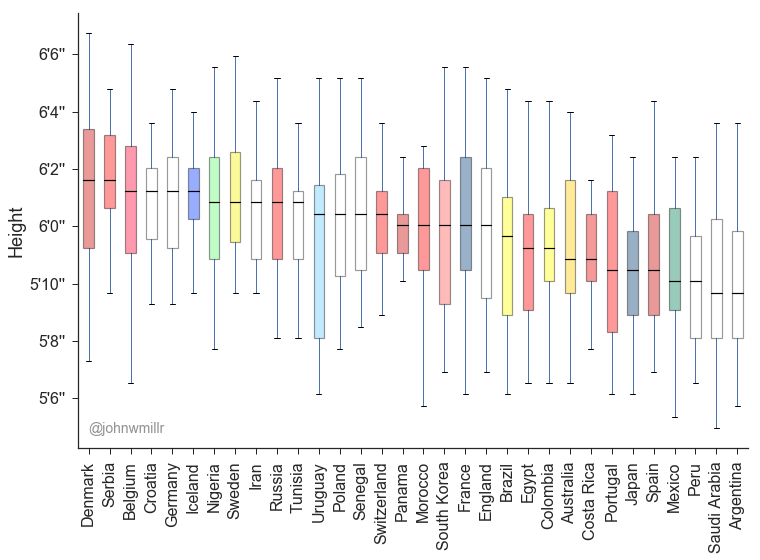

In [247]:
# https://stackoverflow.com/questions/21912634/how-can-i-sort-a-boxplot-in-pandas-by-the-median-values/37871635#37871635
grouped = df.groupby(["nationality"])
df2 = pd.DataFrame({col:vals['height_ft'] for col,vals in grouped})
meds = df2.median()
meds.sort_values(ascending=False, inplace=True)
df2 = df2[meds.index]

boxprops = dict(linestyle='-', linewidth=1, color='black')
whiskerprops = dict(linestyle='-',linewidth=1, color='black')
bps = df2.boxplot(rot=90, figsize=(12,8),
           grid=False, boxprops=boxprops, whiskerprops=whiskerprops, showfliers=False,
                  notch=False, patch_artist=True, return_type='dict')

# Touch up the plot
ax = plt.gca()

# Change color of each box
n = 0
for patch_box, patch_med in zip(bps['boxes'], bps['medians']):    
    patch_box.set_facecolor("#" + jersey_colors[meds.index[n]]['base'])    
    patch_box.set_edgecolor("k")    
    patch_box.set_linewidth(1.2)
    patch_box.set_alpha(0.4)
    patch_med.set_color("k")
    patch_med.set_linewidth(1.2)    
    n += 1

ax.set_ylabel("Height", fontsize=FS+2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(FS) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(FS) 

yticks = np.arange(5.5,6.6,2/12)
pprint_feet = lambda x: "{ft}'{inch:1.0f}''".format(ft=int(np.floor(x)), inch=round(12*(x-np.floor(x))))
ax.set_yticks(yticks)
ax.set_yticklabels(map(pprint_feet, yticks))

x = np.array(ax.get_xlim())
mid = x.sum()-x.mean()
title = "Distributions of height for each team in the 2018 FIFA World Cup"
# ax.text(mid, 6.6, title, fontsize=FS, horizontalalignment='center', weight='bold')     
ax.text(1, 5.4, "@johnwmillr", fontsize=FS-2, alpha=0.5)
plt.savefig("./figures/nations_by_height_no_title.png", format="png", dpi=300, bbox_inches="tight")

### Heights plotted by position

In [9]:
# https://stackoverflow.com/questions/21912634/how-can-i-sort-a-boxplot-in-pandas-by-the-median-values/37871635#37871635
grouped = df.groupby(["type"])
df2 = pd.DataFrame({col:vals['height_ft'] for col,vals in grouped})
meds = df2.median()
meds.sort_values(ascending=False, inplace=True)
# df2 = df2[meds.index]
df2 = df2[pd.Index(['goalkeeper','defender','midfielder','forward'])]

boxprops = dict(linestyle='-', linewidth=1, color='k')
whiskerprops = dict(linestyle='-',linewidth=1, color='k')
bps = df2.plot.box(rot=0, figsize=(8,6),
           grid=False, boxprops=boxprops, whiskerprops=whiskerprops, showfliers=False,
                  notch=False, patch_artist=True, return_type='dict')

# Touch up the plot
ax = plt.gca()

# Change color of each box
n = 0
lw = 1.5
colors = 4*['w']
for patch_box, patch_med in zip(bps['boxes'], bps['medians']):
    patch_box.set_facecolor(colors[n])
    patch_box.set_edgecolor("k")    
    patch_box.set_alpha(0.6)
    patch_med.set_color("k")
    patch_box.set_linewidth(lw)
    patch_med.set_linewidth(1.5)
    patch_med.set_alpha(0.4)
    n += 1

n = 0
a = 0.7
for patch_cap, patch_whisk in zip(bps['caps'], bps['whiskers']):
    patch_cap.set_linewidth(lw)
    patch_cap.set_alpha(a)
    patch_whisk.set_linewidth(lw)
    patch_whisk.set_alpha(a)
    n += 1    

# Add some random jitter to the x-axis
# colors = ['red','seagreen','orange','magenta']
colors = ['magenta','red','orange','skyblue']
# colors = 4*['k']
dots = []
for n,var in enumerate(meds.index):
    x = np.random.normal(n+1, 0.06, size=sum(df2[var].notna()))
    y = df2[var][df2[var].notna()]
    dots.append(plt.plot(x, y, '.', color=colors[n], alpha=0.3, markersize=11))

# Move the scatter plots on top of the box plots
[dot[0].set_zorder(20) for dot in dots]

ax.set_ylabel("Height", fontsize=FS+2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(FS) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(FS) 

yticks = np.arange(5.5,6+8/12,2/12)
pprint_feet = lambda x: "{ft}'{inch:.0f}''".format(ft=int(np.floor(x)), inch=round(12*(x-np.floor(x))))
# pprint_feet = lambda x: "{ft}'{inch:.0f}''           \n({cm:3.0f} cm)            ".format(ft=int(np.floor(x)), inch=round(12*(x-np.floor(x))), cm=x*30.48)
ax.set_yticks(yticks)
ax.set_yticklabels(map(pprint_feet, yticks), fontdict={"horizontalalignment": "right", "verticalalignment": "center"})
# ax.set_xticklabels(["Goalkeeper", "Defender", "Forward", "Midfielder"]);
ax.set_xticklabels(["Goalkeeper", "Defender", "Midfielder", "Forward"]);

x = np.array(ax.get_xlim())
mid = (x.sum()-x.mean())*0.94
title = "Distributions of height by position for each player in the 2018 FIFA World Cup"
# ax.text(mid, 6.75, title, fontsize=FS-3, horizontalalignment='center', weight='bold')     
ax.text(0.58, 5.41, "@johnwmillr", fontsize=FS-2, alpha=0.5);
plt.savefig("./figures/height_by_position_no_title.png", format="png", dpi=300, bbox_inches="tight")

### Other method of making boxplots

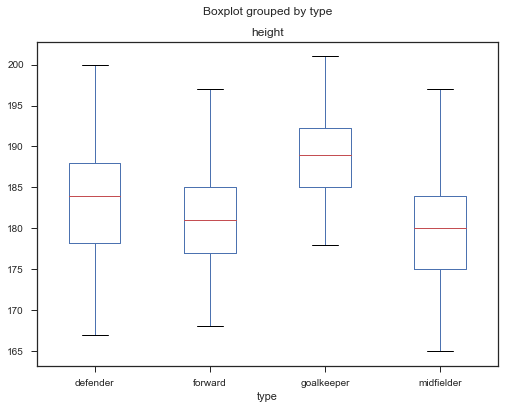

In [256]:
boxprops = dict(linestyle='-', linewidth=1, color='black')
whiskerprops = dict(linestyle='-',linewidth=1, color='black')
df.boxplot(column='height', by='type', rot=0, figsize=(8,6),
           grid=False, boxprops=boxprops, whiskerprops=whiskerprops, showfliers=False, notch=False)

## Weight vs height

In [6]:
positions = list(set(df.type)) # ['defender', 'forward', 'midfielder', 'goalkeeper']
# colors = ['red','magenta','blue','orange']
colors = ['red','orange','magenta','skyblue']
pal = dict(zip(positions,colors))
mrks = {"marker": ['o','v','^','s']}
# mrks = {"marker": 4*['o']}
fg = sns.FacetGrid(data=df, hue='type', palette=pal, aspect=2.5/2, size=6, hue_kws=mrks)
fg.map(plt.scatter, 'weight_lbs', 'height_ft', alpha=0.4, s=60)
# fg.map(sns.jointplot, 'weight_lbs', 'height_ft')
# fg.map(sns.regplot, 'weight_lbs', 'height_ft')

fg.set_xlabels("Weight (lbs)", fontsize=FS)
fg.set_ylabels("Height", fontsize=FS)
ax = plt.gca()

yticks = np.arange(5.5,6+8/12,2/12)
pprint_feet = lambda x: "{ft}'{inch:.0f}''".format(ft=int(np.floor(x)), inch=round(12*(x-np.floor(x))))
# pprint_feet = lambda x: "{ft}'{inch:.0f}''           \n({cm:3.0f} cm)            ".format(ft=int(np.floor(x)), inch=round(12*(x-np.floor(x))), cm=x*30.48)
ax.set_yticks(yticks)
ax.set_yticklabels(map(pprint_feet, yticks), fontdict={"horizontalalignment": "right", "verticalalignment": "center"})

# xticks = ax.get_xticks()
# pprint_weight = lambda x: "{lbs:.0f} (lbs)\n{kg:.0f} (kg)".format(lbs=x, kg=x*0.453592)
# ax.set_xticklabels(pprint_weight(xticks), fontdict={"horizontalalignment": "center"})

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(FS) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(FS) 
ax.legend(loc=(0.7,0.1), frameon=True, facecolor='w', edgecolor='k', fontsize=FS-3, framealpha=1)
x = np.array(ax.get_xlim())
mid = x.sum()-x.mean()
title = "Height and weight of each player in the 2018 FIFA World Cup"
# ax.text(mid, 6.7, title, fontsize=FS, horizontalalignment='center', weight='bold')     
ax.text(207, 5.37, "@johnwmillr", fontsize=FS-2, alpha=0.5)

Text(207,5.37,'@johnwmillr')

In [7]:
fg.savefig("./figures/height_vs_weight_by_position_v2_no_title.png", format="png", dpi=300, bbox_inches="tight")

## Birthdays

In [401]:
fg = sns.FacetGrid(data=df, hue='type', palette=pal, aspect=2.5/2, size=8, hue_kws=mrks)
fg.map(plt.scatter, 'date_of_birth', 'weight', alpha=0.5, s=100)

## Interactive plots

In [3]:
import mpld3
from mpld3 import plugins
# %matplotlib inline
mpld3.enable_notebook()

In [4]:
# Define some CSS to control our custom labels
css = """
table
{
  border-collapse: collapse;
}
th
{
  color: #ffffff;
  background-color: #000000;
}
td
{
  background-color: #cccccc;
}
table, th, td
{
  font-family:Arial, Helvetica, sans-serif;
  border: 1px solid black;
  text-align: center;
}
img
{
    border-radius: 8px;
    height: auto;        
}
center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    width: 50%;
}
"""

## Boxplots of height by player position

In [13]:
df.head()

country_code date_of_birth gender  height                id  jersey_number  \
0          RUS    1986-04-08   male     185   sr:player:13274              1   
1          RUS    1990-09-19   male     187  sr:player:146393              2   
2          RUS    1993-07-29   male     190   sr:player:94759              3   
3          RUS    1979-07-14   male     186   sr:player:13303              4   
4          RUS    1989-03-24   male     191   sr:player:84767              5   

                  name nationality nickname preferred_foot        type  \
0       Akinfeev, Igor      Russia      NaN          right  goalkeeper   
1     Fernandes, Mario      Russia      NaN          right    defender   
2        Kutepov, Ilya      Russia      NaN          right    defender   
3  Ignashevich, Sergey      Russia      NaN          right    defender   
4      Semenov, Andrey      Russia      NaN          right    defender   

   weight  weight_lbs  height_ft  
0      83   182.98346   6.069557  
1      79   174.16498   6.135174  
2      82   180.77884   6.233599  
3      84   185.18808   6.102366  
4      87   191.80194   6.266408

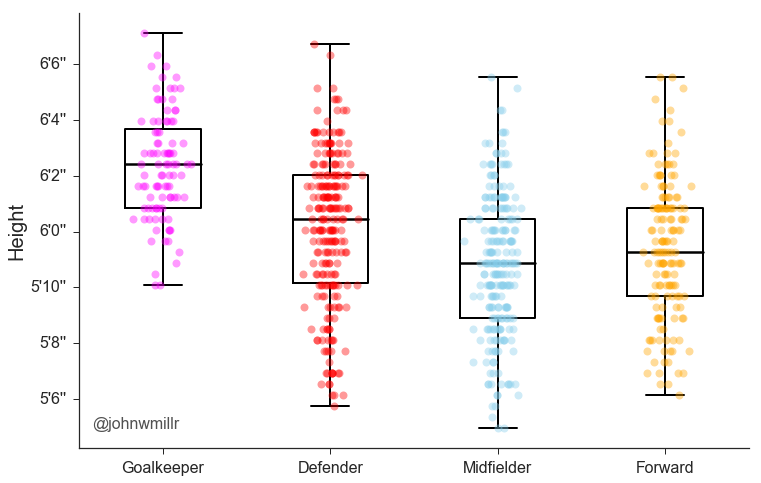

In [42]:
# Group the height data by player position
grouped = df.groupby(["type"])
df2 = pd.DataFrame({col:vals['height_ft'] for col,vals in grouped})
df2 = df2[pd.Index(['goalkeeper','defender','midfielder','forward'])]

# Match the indices from the original DF to the grouped DF
old_df_indices = list(grouped.indices.values())
new_order=[2,0,3,1]
old_df_indices = [ old_df_indices[i] for i in new_order]
old_df_indices = [idx for sublist in old_df_indices for idx in sublist] # flatten the list

# Create the data tips
names = df.name
# imgs = ['<img src="{}" width="80">'.format(url) for url in all_images]
labels = []
cols_to_drop = ['country_code','gender','id','nickname','name'] 
for i in old_df_indices:
    label = df.iloc[[i], :].T    
    label.columns = [names[i]]
#     html = label.drop([], axis=0).to_html() + '\n' + imgs[i]
    html = label.drop(cols_to_drop, axis=0).to_html()
    labels.append(html)
           
# --------------------------
# Do the actual plotting
bps = df2.boxplot(rot=0, figsize=(12,8), grid=False, showfliers=False, return_type='dict')
c,lw = 'k',2
plt.setp(bps['boxes'], color=c, linewidth=lw)
plt.setp(bps['caps'], color=c, linewidth=lw)
plt.setp(bps['whiskers'], color=c, linewidth=lw)
plt.setp(bps['medians'], color=c, linewidth=lw+.5)

fig, ax = plt.gcf(), plt.gca()

# Add some random jitter to the x-axis
colors = ['magenta','red','skyblue','orange']
dots = []
ms = 8
all_random_x = np.array([])
all_y = np.array([])
for n,var in enumerate(df2.columns.values):
    x = np.random.normal(n+1, 0.06, size=sum(df2[var].notna()))
    y = df2[var][df2[var].notna()]
    dots.append(plt.plot(x, y, 'o', color=colors[n], alpha=0.4, markersize=ms))
    
    # Add the points we'll mouse over
    all_random_x = np.append(all_random_x, x)
    all_y = np.append(all_y, y)

# Move the scatter plots on top of the box plots
[dot[0].set_zorder(20) for dot in dots]

# Adjust the Y-tick labels
ax.set_ylabel("Height", fontsize=FS+4)
yticks = np.arange(5.5,6+8/12,2/12)
pprint_feet = lambda x: "{ft}'{inch:.0f}''".format(ft=int(np.floor(x)), inch=round(12*(x-np.floor(x))))
# pprint_feet = lambda x: "{ft}'{inch:.0f}''           \n({cm:3.0f} cm)            ".format(ft=int(np.floor(x)), inch=round(12*(x-np.floor(x))), cm=x*30.48)
ax.set_yticks(yticks)
ax.set_yticklabels(map(pprint_feet, yticks), fontdict={"horizontalalignment": "right", "verticalalignment": "center"})
ax.set_xticklabels(["Goalkeeper", "Defender", "Midfielder", "Forward"], fontsize=FS);

ax.text(0.58, 5.41, "@johnwmillr", fontsize=FS, alpha=0.8);

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(FS) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(FS)

# https://mpld3.github.io/examples/html_tooltips.html
points = ax.plot(all_random_x, all_y, 'ko', mec='k', ms=ms, alpha=0.0, label="")
tooltip = plugins.PointHTMLTooltip(points[0], labels, voffset=10, hoffset=10, css=css)
plugins.connect(fig, tooltip)
[point.set_zorder(30) for point in points]

# mpld3.display()
plotname = 'mpld3_{}_by_position'.format('height','score')
mpld3.save_html(fig, './figures/'+plotname+'.html', figid=plotname, template_type='simple')

### Height vs. weight

In [5]:
# Create the data tips
names = df.name
# imgs = ['<img src="{}" width="80">'.format(url) for url in all_images]
labels = []
for i in range(len(df)):
    label = df.iloc[[i], :].T    
    label.columns = [names[i]]
#     html = label.drop([], axis=0).to_html() + '\n' + imgs[i]
    html = label.drop([], axis=0).to_html()
    labels.append(html)

# --------------------------
# Do the actual plotting
# Scatter plot the data
fig, ax = plt.subplots(figsize=(12,10))
ax.grid(True, alpha=0.3)

term1,term2 = 'weight_lbs','height_ft'

x,y = df[term1],df[term2]
b = []
ms = 10
b.append(plt.plot(x, y, 'ro', ms=ms, alpha=0.5))

# https://mpld3.github.io/examples/html_tooltips.html
points = ax.plot(df[term1], df[term2], 'ko', mec='k', ms=ms, alpha=0.0, label="") # Plot all of the data
tooltip = plugins.PointHTMLTooltip(points[0], labels, voffset=10, hoffset=10, css=css)
plugins.connect(fig, tooltip)

ax.set_xlabel(term1, fontsize=FS)
ax.set_ylabel(term2, fontsize=FS)
for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(FS-2) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(FS-2)
# ax.set_title("Pitchfork album review scores as a function of lexical diversity", fontsize=FS)
# ax.annotate("@johnwmillr", (0.2,.8), fontsize=FS-4, alpha=0.5)
# ax.legend(loc=(0.8,.2), frameon=True, facecolor='w', edgecolor='k', fontsize=FS-4, framealpha=0.4)
# ax.set_xlim([datetime.strptime('1984', '%Y'), datetime.strptime('2019', '%Y')])
# ax.set_ylim([-10, 250])

mpld3.display()
# plotname = 'mpld3_{}_vs_{}'.format('lexdiv','score')
# mpld3.save_html(fig, './figures/'+plotname+'.html', figid=plotname, template_type='simple')